# Use Case 1 - Municipality Analysis

In this notebook we'll show you how you can do a municipality level analysis by joining datasets from a wide array of sources and merging it with INEGI's shapefiles to create beautiful maps and visualizations.

## Objective

Understand each municipality's financial infrastructure and merge that information with sociodemographic data from INEGI's household and economic census.

## Imports and setup

First, let's make the standard imports.

In [2]:
import requests 
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from matplotlib import cm
import numpy as np
import matplotlib.colors as clr
import seaborn as sns

token = "" # Your TOKEN goes here
url = 'http://api.tukanmx.com/v1/retrieve/'

headers = {
"Content-Type": "application/json",
"Authorization": "Token " + token
}

In order to make the maps, we will also need to install the `geopandas` package and read the shapefiles from the `aux_files` folder which have already been made available in this repository.

**Tip:** if you're using a Windows machine and are having trouble installing `geopandas` referr to [this article](https://iotespresso.com/how-to-install-geopandas-on-windows/).

In [3]:
import geopandas as gpd

Now that we have `geopandas` installed we load INEGI's shapefiles, and a `csv` file that contains a mapping for TUKAN's geography id's and INEGI's municipality codes.

In [4]:
df_edo = gpd.read_file("../aux_files/00ent.shp")
df_mun = gpd.read_file("../aux_files/00mun.shp")

#INEGI - TUKAN geography mapping

inegi_tukan_map = pd.read_csv('../aux_files/inegi_geography_map.csv', dtype={'CVEGEO':'str'})

And we apply the mapping to the shapefiles.

In [5]:
df_edo = pd.merge(df_edo, inegi_tukan_map[['CVEGEO', 'CVEGEO_tukan']], how = 'left', on = 'CVEGEO')
df_mun = pd.merge(df_mun, inegi_tukan_map[['CVEGEO', 'CVEGEO_tukan']], how = 'left', on = 'CVEGEO')

#Rename columns
df_edo.rename(columns = {'CVEGEO_tukan':'geography__ref'}, inplace = True)
df_mun.rename(columns = {'CVEGEO_tukan':'geography__ref'}, inplace = True)

### Pre-defined functions

Finally we define a couple of functions that will help us with handling the data and making requests to TUKAN's API.

In [6]:
# Get the dictionary for a table
def get_table_dictionary(table_id):

    global url
    global headers

    payload = {
    "type":"variable_dict",
    "data_table": table_id,
    "operation": "all"
    }

    response = requests.request("POST", url, headers=headers, data = json.dumps(payload))
    var_dict = pd.DataFrame(response.json()[table_id + '_variables_dictionary'])

    return(var_dict)

# Get the dictionary for a category

def get_category_dictionary(category_id):

  global url
  global headers

  payload = {
    "type":"category_dict",
    "category": category_id,
    "operation": "all"
  }

  response = requests.request("POST", url, headers=headers, data = json.dumps(payload))
  category_dict = pd.DataFrame(response.json()[category_id + '_dictionary'])
  
  return(category_dict)


# Make a date request to a table
def get_tukan_api_request(payload):

    metadata_payload = {
        "type": "data_table",
	    "operation": "metadata",
	    "language": payload['language'],
        "request": payload['request'],
        "categories": payload['categories']
    }

    response = requests.request("POST", url, headers=headers, data = json.dumps(payload))
    md_response = requests.request("POST", url = "http://api.tukanmx.com/v1/control/", headers = headers, data = json.dumps(metadata_payload))
    try:
        data = pd.DataFrame(response.json()['data'])
        print("Success getting the data")
    except:
        print(response.content)

    data['date'] = pd.to_datetime(data['date'])
    data.replace({'':np.nan}, inplace = True)

    try:
        categories = md_response.json()['data']['categories']
    except:
        categories = []

    return({
        'data':data,
        'variables':md_response.json()['data']['variables'], 
        'categories': categories, 
        'metadata': md_response.json()['data']['data_table']
    }) 

## Choosing our data

Now that we have all the basic imports, it's time to choos the datasets we'll be extracting information from.

* Economic Census - id: `mex_inegi_econ_census`
* Census - Household Indicators - id: `mex_inegi_census_households`
* Census - Population Indicators - id: `mex_inegi_census_pop`
* Commercial Banks - Operational Data - id: `mex_cnbv_cb_operational`
* Commercial Banks - Funding Data - id: `mex_cnbv_cb_funding_data`

### Economic Census

Let's start with the Economic Census and explore the dictionary.

In [7]:
econ_census_dic = get_table_dictionary('mex_inegi_econ_census')

We can then explore the dictionary in our data viewer or directly in TUKAN's web dashboard to obtain the variable id's for the following indicators:

* Total expenses - `5a0004d32157b65`.
* Total revenue - `d11b1e4d6a55d5a`.
* Economic units - `942f60788525ce9`.
* Stock of fixed assets - `940b060ccbf7cb7`

Since this is a pretty large dataset and we're interested in obtaining the highest level of granularity, we'll iterate over the `economic_activity` category to make one request per category and avoid a timeout in our request.

Be patient, this may take a couple of minutes.

In [8]:
econ_activities = ['169c33ccdd66d77', '23cf92d98dd7c11', '29daaeb36fea1ab',
       '36348912d8470dd', '3726993cc9fecab', '44d246411040129',
       '457155464609a2f', '4bc9836c2d7e60a', '6b36ca46b6cfd91',
       '990b94ebe38c9ca', 'a07267f78158c2c', 'afcc312ccddfcc1',
       'bbb49ae78601ab9', 'be676b5dd921cb7', 'd05c3b2b73d75fc',
       'd35f5b82779e7d5', 'e426cc87d0540ab', 'faa2a8d0af8a72c',
       'fcb303b72a98f6c', 'feb7bb4445c808d'] #The economic activity id's for the main SCIAN sectors

econ_df = pd.DataFrame()
for econ in econ_activities:
    payload = {
        "type": "data_table",
        "operation": "sum",
        "language": "en",
        "categories": {
            "economic_activity": [econ],
            "geography": "all"
        },
        "request": [
            {
                "table": "mex_inegi_econ_census",
                "variables": [
                    "942f60788525ce9",
                    "d11b1e4d6a55d5a",
                    "5a0004d32157b65",
                    "940b060ccbf7cb7"
                ]
            }
        ]
    }

    try:
        econ_response = get_tukan_api_request(payload)
        econ_data = econ_response['data'] 
        econ_df = econ_df.append(econ_data)
    except:
        print("Request failed", econ)

Success getting the data
Success getting the data
Success getting the data
Success getting the data
Success getting the data
Success getting the data
Success getting the data
Success getting the data
Success getting the data
Success getting the data
Success getting the data
Success getting the data
Success getting the data
Success getting the data
Success getting the data
Success getting the data
Success getting the data
Success getting the data
Success getting the data
Success getting the data


We can explore the variables definition with the following code:

In [9]:
econ_response['variables']

[{'ref': '5a0004d32157b65',
  'display_name': 'Total expenses',
  'description': 'It is the total amount that the economic unit allocated to the consumption of goods, services and other financial and tax expenditures and donations without compensation to individuals and companies.',
  'unit': 'Mexican pesos'},
 {'ref': '940b060ccbf7cb7',
  'display_name': 'Stock of fixed assets',
  'description': 'It is the updated value of all those goods, owned by the economic unit - whose useful life is greater than one year - that have the capacity to produce or provide the necessary conditions for the generation of goods and services. Includes fixed assets owned by the economic unit rented to third parties; those that you normally use, even when they are temporarily assigned to other economic units of the same company; those produced by the economic unit for its own use and the fixed assets obtained under financial leasing. It excludes fixed assets that are normally used by other economic units of

And now we can compute interesting indicators such as: the revenue  and asset turnover per economic unit.

In [10]:
# Remove all negative revenue values:

econ_df.loc[:,'revenue_per_unit'] = econ_df.loc[:,'d11b1e4d6a55d5a']/econ_df.loc[:,'942f60788525ce9']
econ_df.loc[:,'asset_turnover'] = (econ_df.loc[:,'d11b1e4d6a55d5a']/econ_df.loc[:,'940b060ccbf7cb7'])

In [11]:
econ_df.head()

,date,economic_activity__ref,economic_activity,geography__ref,geography,5a0004d32157b65,940b060ccbf7cb7,942f60788525ce9,d11b1e4d6a55d5a,revenue_per_unit,asset_turnover
0,2019-01-01,169c33ccdd66d77,Wholesale trade,001f860c459c018,Texcoco,5.403077e+09,1.402080e+09,277.0,7.114633e+09,2.568460e+07,5.074342
1,2019-01-01,169c33ccdd66d77,Wholesale trade,00341dc0d8812f8,Cosolapa,NaN,NaN,6.0,NaN,NaN,NaN
2,2019-01-01,169c33ccdd66d77,Wholesale trade,003ed897a27e3ca,Sucilá,3.257000e+06,3.110000e+05,5.0,3.698000e+06,7.396000e+05,11.890675
3,2019-01-01,169c33ccdd66d77,Wholesale trade,0042ca722cb0460,Huatlatlauca,NaN,NaN,2.0,NaN,NaN,NaN
4,2019-01-01,169c33ccdd66d77,Wholesale trade,004b8d7309533e4,Zozocolco de Hidalgo,NaN,NaN,2.0,NaN,NaN,NaN


### Commercial Banks - Operational Data

In this section we'll incorporate financial infrastructure data to enrich our dataset. In this case, we'll explore the amount of financial infrastructure across 5 indicators and explore the evolution in recent years:

* ATMs - `ad1841c2825df92`
* Branches - `2eee037c67fbe81`
* Establishments with PoS terminals - `cb5f1f6fad63925`
* Credit Card Contracts - `8bcd017026f8186`
* Transactions in PoS terminals - `3b0677902e52763`

In [17]:
dates = ["2019-12-01", None] #None is for getting the most recent data

operational_bank_data = pd.DataFrame()

for date in dates:
    payload = {
        "type": "data_table",
        "operation": "sum",
        "language": "en",
        "categories": {
            "geography": "all"
        },
        "request": [
            {
                "table": "mex_cnbv_cb_operational",
                "variables": [
                    "ad1841c2825df92",
                    "8bcd017026f8186",
                    "cb5f1f6fad63925",
                    "2eee037c67fbe81",
                    "3b0677902e52763"
                ]
            }
        ],
        "from": date,
        "to": date
    }

    try:
        operational_bank_response = get_tukan_api_request(payload)
        operational_bank_data = operational_bank_data.append(operational_bank_response['data']) 
    except:
        print("Request failed")

Success getting the data
Success getting the data


In [18]:
operational_bank_data.head()

,date,geography__ref,geography,2eee037c67fbe81,3b0677902e52763,8bcd017026f8186,ad1841c2825df92,cb5f1f6fad63925
0,2019-12-01,001f860c459c018,Texcoco,37.0,329403.0,72745.0,123.0,1397.0
1,2019-12-01,00341dc0d8812f8,Cosolapa,NaN,2830.0,240.0,3.0,32.0
2,2019-12-01,003ed897a27e3ca,Sucilá,NaN,2125.0,51.0,NaN,3.0
3,2019-12-01,0042ca722cb0460,Huatlatlauca,NaN,NaN,51.0,NaN,NaN
4,2019-12-01,004b8d7309533e4,Zozocolco de Hidalgo,NaN,69.0,120.0,1.0,4.0


And now we merge it with the Economic Census dataset.

In [19]:
# We create new dataframe where we'll merge all of the relevant data.
main_df = pd.merge(econ_df, operational_bank_data, how = "left", on = ["geography", "geography__ref"], suffixes=("_econ", "_operational"))
main_df.head()

,date_econ,economic_activity__ref,economic_activity,geography__ref,geography,5a0004d32157b65,940b060ccbf7cb7,942f60788525ce9,d11b1e4d6a55d5a,revenue_per_unit,asset_turnover,date_operational,2eee037c67fbe81,3b0677902e52763,8bcd017026f8186,ad1841c2825df92,cb5f1f6fad63925
0,2019-01-01,169c33ccdd66d77,Wholesale trade,001f860c459c018,Texcoco,5.403077e+09,1.402080e+09,277.0,7.114633e+09,2.568460e+07,5.074342,2019-12-01,37.0,329403.0,72745.0,123.0,1397.0
1,2019-01-01,169c33ccdd66d77,Wholesale trade,001f860c459c018,Texcoco,5.403077e+09,1.402080e+09,277.0,7.114633e+09,2.568460e+07,5.074342,2021-09-01,33.0,233229.0,71295.0,129.0,1617.0
2,2019-01-01,169c33ccdd66d77,Wholesale trade,00341dc0d8812f8,Cosolapa,NaN,NaN,6.0,NaN,NaN,NaN,2019-12-01,NaN,2830.0,240.0,3.0,32.0
3,2019-01-01,169c33ccdd66d77,Wholesale trade,00341dc0d8812f8,Cosolapa,NaN,NaN,6.0,NaN,NaN,NaN,2021-09-01,NaN,2648.0,332.0,3.0,57.0
4,2019-01-01,169c33ccdd66d77,Wholesale trade,003ed897a27e3ca,Sucilá,3.257000e+06,3.110000e+05,5.0,3.698000e+06,7.396000e+05,11.890675,2019-12-01,NaN,2125.0,51.0,NaN,3.0


In the next chunk we will create an aggregate dictionary file so we can keep track of all the variables we are analyzing.

In [20]:
variable_df = pd.DataFrame(econ_response['variables'])
variable_df = variable_df.append(pd.DataFrame(operational_bank_response['variables'])).reset_index(drop = True)
variable_df

,ref,display_name,description,unit
0,5a0004d32157b65,Total expenses,It is the total amount that the economic unit ...,Mexican pesos
1,940b060ccbf7cb7,Stock of fixed assets,"It is the updated value of all those goods, ow...",Mexican pesos
2,942f60788525ce9,Economic units,"Entity (institution, company, business or pers...",Unit
3,d11b1e4d6a55d5a,Total revenue,It is the total amount that the economic unit ...,Mexican pesos
4,2eee037c67fbe81,Branches,,Unit
5,3b0677902e52763,Transactions in POS terminals,Number of transactions made through point-of-s...,Unit
6,8bcd017026f8186,Credit card contracts,,Unit
7,ad1841c2825df92,ATMs,,Unit
8,cb5f1f6fad63925,Establishments with POS terminals,Number of establishments that own at least one...,Unit


### Commercial Banks - Funding Data

In this section we'll incorporate financial infrastructure data to enrich our dataset. In this case, we'll explore the amount of financial infrastructure across 5 indicators and explore the evolution in recent years:

* Transactional accounts - `0441165e44d8219`
* Balance of transactional accounts - `225d0486113b156`
* Payroll accounts - `bbbd13cd926bcdf`
* Balance of transactional accounts - `ea6eb8c540e7aae`

In [21]:
dates = ["2019-12-01", None] #None is for getting the most recent data

funding_bank_data = pd.DataFrame()

for date in dates:
    payload = {
        "type": "data_table",
        "operation": "sum",
        "language": "en",
        "group_by": [
            "geography"
        ],
        "categories": {
            "geography": "all"
        },
        "request": [
            {
                "table": "mex_cnbv_cb_funding_data",
                "variables": [
                    "bbbd13cd926bcdf",
                    "0441165e44d8219",
                    "ea6eb8c540e7aae",
                    "225d0486113b156"
                ]
            }
        ],
        "from": date,
        "to": date
    }

    try:
        funding_bank_response = get_tukan_api_request(payload)
        funding_bank_data = funding_bank_data.append(funding_bank_response['data']) 
    except:
        print("Request failed")

Success getting the data
Success getting the data


In [22]:
funding_bank_data

,date,geography__ref,geography,0441165e44d8219,225d0486113b156,bbbd13cd926bcdf,ea6eb8c540e7aae
0,2019-12-01,001f860c459c018,Texcoco,249735.0,5.502150e+09,70447.0,957988442.0
1,2019-12-01,00341dc0d8812f8,Cosolapa,112.0,6.863100e+04,NaN,NaN
2,2019-12-01,003ed897a27e3ca,Sucilá,386.0,9.531900e+04,NaN,NaN
3,2019-12-01,0042ca722cb0460,Huatlatlauca,200.0,4.846500e+04,NaN,NaN
4,2019-12-01,004b8d7309533e4,Zozocolco de Hidalgo,70.0,4.265300e+04,NaN,NaN
...,...,...,...,...,...,...,...
2426,2021-09-01,ff7ccf1d5a2d8c7,San Blas Atempa,444.0,7.490100e+04,NaN,NaN
2427,2021-09-01,ffc395b30ae92d9,Tezoyuca,6678.0,3.104541e+07,351.0,1863500.0
2428,2021-09-01,ffc93354918a89a,Uruachi,82.0,4.090900e+04,NaN,NaN
2429,2021-09-01,ffda8cad00e3ca3,Juchitepec,6981.0,5.326002e+07,312.0,2855321.0


In [23]:
variable_df = variable_df.append(pd.DataFrame(funding_bank_response['variables'])).reset_index(drop = True)
variable_df

,ref,display_name,description,unit
0,5a0004d32157b65,Total expenses,It is the total amount that the economic unit ...,Mexican pesos
1,940b060ccbf7cb7,Stock of fixed assets,"It is the updated value of all those goods, ow...",Mexican pesos
2,942f60788525ce9,Economic units,"Entity (institution, company, business or pers...",Unit
3,d11b1e4d6a55d5a,Total revenue,It is the total amount that the economic unit ...,Mexican pesos
4,2eee037c67fbe81,Branches,,Unit
5,3b0677902e52763,Transactions in POS terminals,Number of transactions made through point-of-s...,Unit
6,8bcd017026f8186,Credit card contracts,,Unit
7,ad1841c2825df92,ATMs,,Unit
8,cb5f1f6fad63925,Establishments with POS terminals,Number of establishments that own at least one...,Unit
9,0441165e44d8219,Transactional accounts,Total transactional accounts,Unit


In [24]:
# We create new dataframe where we'll merge all of the relevant data.

main_df = pd.merge(main_df, funding_bank_data, how = "left", left_on = ["geography", "geography__ref", "date_operational"], right_on = ["geography", "geography__ref", "date"])
main_df.drop('date', axis = 1, inplace = True)
main_df.head()

,date_econ,economic_activity__ref,economic_activity,geography__ref,geography,5a0004d32157b65,940b060ccbf7cb7,942f60788525ce9,d11b1e4d6a55d5a,revenue_per_unit,...,date_operational,2eee037c67fbe81,3b0677902e52763,8bcd017026f8186,ad1841c2825df92,cb5f1f6fad63925,0441165e44d8219,225d0486113b156,bbbd13cd926bcdf,ea6eb8c540e7aae
0,2019-01-01,169c33ccdd66d77,Wholesale trade,001f860c459c018,Texcoco,5.403077e+09,1.402080e+09,277.0,7.114633e+09,2.568460e+07,...,2019-12-01,37.0,329403.0,72745.0,123.0,1397.0,249735.0,5.502150e+09,70447.0,9.579884e+08
1,2019-01-01,169c33ccdd66d77,Wholesale trade,001f860c459c018,Texcoco,5.403077e+09,1.402080e+09,277.0,7.114633e+09,2.568460e+07,...,2021-09-01,33.0,233229.0,71295.0,129.0,1617.0,271120.0,7.633441e+09,79746.0,1.372202e+09
2,2019-01-01,169c33ccdd66d77,Wholesale trade,00341dc0d8812f8,Cosolapa,NaN,NaN,6.0,NaN,NaN,...,2019-12-01,NaN,2830.0,240.0,3.0,32.0,112.0,6.863100e+04,NaN,NaN
3,2019-01-01,169c33ccdd66d77,Wholesale trade,00341dc0d8812f8,Cosolapa,NaN,NaN,6.0,NaN,NaN,...,2021-09-01,NaN,2648.0,332.0,3.0,57.0,40.0,8.682400e+04,NaN,NaN
4,2019-01-01,169c33ccdd66d77,Wholesale trade,003ed897a27e3ca,Sucilá,3.257000e+06,3.110000e+05,5.0,3.698000e+06,7.396000e+05,...,2019-12-01,NaN,2125.0,51.0,NaN,3.0,386.0,9.531900e+04,NaN,NaN


### Census - Household Indicators

Now we'll add census household indicators such as: internet accesibility, pay-tv services, car ownership, etc.

In [25]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "en",
    "group_by": [
        "geography"
    ],
    "categories": {
        "geography": "all"
    },
    "request": [
        {
            "table": "mex_inegi_census_households",
            "variables": [
                "721673cdde1ba0e",
                "693c82061110ee7",
                "d905292764361c1",
                "52b325642f3e5ab",
                "4c473159bc750ea",
                "1022d3e22c3bf67"
            ]
        }
    ]
}

try:
    census_house_response = get_tukan_api_request(payload)
    census_house_data = census_house_response['data'] 
except:
    print("Request failed")

Success getting the data


In [26]:
variable_df = variable_df.append(pd.DataFrame(census_house_response['variables'])).reset_index(drop = True)
variable_df

,ref,display_name,description,unit
0,5a0004d32157b65,Total expenses,It is the total amount that the economic unit ...,Mexican pesos
1,940b060ccbf7cb7,Stock of fixed assets,"It is the updated value of all those goods, ow...",Mexican pesos
2,942f60788525ce9,Economic units,"Entity (institution, company, business or pers...",Unit
3,d11b1e4d6a55d5a,Total revenue,It is the total amount that the economic unit ...,Mexican pesos
4,2eee037c67fbe81,Branches,,Unit
5,3b0677902e52763,Transactions in POS terminals,Number of transactions made through point-of-s...,Unit
6,8bcd017026f8186,Credit card contracts,,Unit
7,ad1841c2825df92,ATMs,,Unit
8,cb5f1f6fad63925,Establishments with POS terminals,Number of establishments that own at least one...,Unit
9,0441165e44d8219,Transactional accounts,Total transactional accounts,Unit


In [27]:
main_df = pd.merge(main_df, census_house_data, how = "left", on = ["geography", "geography__ref"])
main_df.head()

,date_econ,economic_activity__ref,economic_activity,geography__ref,geography,5a0004d32157b65,940b060ccbf7cb7,942f60788525ce9,d11b1e4d6a55d5a,revenue_per_unit,...,225d0486113b156,bbbd13cd926bcdf,ea6eb8c540e7aae,date,1022d3e22c3bf67,4c473159bc750ea,52b325642f3e5ab,693c82061110ee7,721673cdde1ba0e,d905292764361c1
0,2019-01-01,169c33ccdd66d77,Wholesale trade,001f860c459c018,Texcoco,5.403077e+09,1.402080e+09,277.0,7.114633e+09,2.568460e+07,...,5.502150e+09,70447.0,9.579884e+08,2020-01-01,32984.0,11242.0,16870.0,29277.0,72078.0,64704.0
1,2019-01-01,169c33ccdd66d77,Wholesale trade,001f860c459c018,Texcoco,5.403077e+09,1.402080e+09,277.0,7.114633e+09,2.568460e+07,...,7.633441e+09,79746.0,1.372202e+09,2020-01-01,32984.0,11242.0,16870.0,29277.0,72078.0,64704.0
2,2019-01-01,169c33ccdd66d77,Wholesale trade,00341dc0d8812f8,Cosolapa,NaN,NaN,6.0,NaN,NaN,...,6.863100e+04,NaN,NaN,2020-01-01,980.0,194.0,2175.0,702.0,4126.0,3437.0
3,2019-01-01,169c33ccdd66d77,Wholesale trade,00341dc0d8812f8,Cosolapa,NaN,NaN,6.0,NaN,NaN,...,8.682400e+04,NaN,NaN,2020-01-01,980.0,194.0,2175.0,702.0,4126.0,3437.0
4,2019-01-01,169c33ccdd66d77,Wholesale trade,003ed897a27e3ca,Sucilá,3.257000e+06,3.110000e+05,5.0,3.698000e+06,7.396000e+05,...,9.531900e+04,NaN,NaN,2020-01-01,275.0,108.0,754.0,204.0,1177.0,1025.0


### Census - Population Indicators

Now we'll add census population indicators such as: scholarity, access to health services and occupied population.

In [28]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "en",
    "group_by": [
        "geography",
        "sex"
    ],
    "categories": {
        "geography": "all",
        "sex": [
            "fb2fa3c93cb0a9e"
        ]
    },
    "request": [
        {
            "table": "mex_inegi_census_people",
            "variables": [
                "9e4acf2e72165d0",
                "e7f9870a5f82f9e",
                "882a7fc317bec5a",
                "c6db776be76685f",
                "5df12d713e7c512",
                "8bedb067c13500a"
            ]
        }
    ]
}

try:
    census_pop_response = get_tukan_api_request(payload)
    census_pop_data = census_pop_response['data'] 
except:
    print("Request failed")

Success getting the data


In [29]:
variable_df = variable_df.append(pd.DataFrame(census_pop_response['variables'])).reset_index(drop = True)
variable_df

,ref,display_name,description,unit
0,5a0004d32157b65,Total expenses,It is the total amount that the economic unit ...,Mexican pesos
1,940b060ccbf7cb7,Stock of fixed assets,"It is the updated value of all those goods, ow...",Mexican pesos
2,942f60788525ce9,Economic units,"Entity (institution, company, business or pers...",Unit
3,d11b1e4d6a55d5a,Total revenue,It is the total amount that the economic unit ...,Mexican pesos
4,2eee037c67fbe81,Branches,,Unit
5,3b0677902e52763,Transactions in POS terminals,Number of transactions made through point-of-s...,Unit
6,8bcd017026f8186,Credit card contracts,,Unit
7,ad1841c2825df92,ATMs,,Unit
8,cb5f1f6fad63925,Establishments with POS terminals,Number of establishments that own at least one...,Unit
9,0441165e44d8219,Transactional accounts,Total transactional accounts,Unit


In [30]:
main_df = pd.merge(main_df, census_pop_data, how = "left", on = ["geography", "geography__ref", "date"])
main_df.head()

,date_econ,economic_activity__ref,economic_activity,geography__ref,geography,5a0004d32157b65,940b060ccbf7cb7,942f60788525ce9,d11b1e4d6a55d5a,revenue_per_unit,...,721673cdde1ba0e,d905292764361c1,sex__ref,sex,5df12d713e7c512,882a7fc317bec5a,8bedb067c13500a,9e4acf2e72165d0,c6db776be76685f,e7f9870a5f82f9e
0,2019-01-01,169c33ccdd66d77,Wholesale trade,001f860c459c018,Texcoco,5.403077e+09,1.402080e+09,277.0,7.114633e+09,2.568460e+07,...,72078.0,64704.0,fb2fa3c93cb0a9e,Both Sexes,54036.0,183119.0,137862.0,212794.0,7211.0,134848.0
1,2019-01-01,169c33ccdd66d77,Wholesale trade,001f860c459c018,Texcoco,5.403077e+09,1.402080e+09,277.0,7.114633e+09,2.568460e+07,...,72078.0,64704.0,fb2fa3c93cb0a9e,Both Sexes,54036.0,183119.0,137862.0,212794.0,7211.0,134848.0
2,2019-01-01,169c33ccdd66d77,Wholesale trade,00341dc0d8812f8,Cosolapa,NaN,NaN,6.0,NaN,NaN,...,4126.0,3437.0,fb2fa3c93cb0a9e,Both Sexes,2285.0,11015.0,6457.0,10542.0,59.0,6388.0
3,2019-01-01,169c33ccdd66d77,Wholesale trade,00341dc0d8812f8,Cosolapa,NaN,NaN,6.0,NaN,NaN,...,4126.0,3437.0,fb2fa3c93cb0a9e,Both Sexes,2285.0,11015.0,6457.0,10542.0,59.0,6388.0
4,2019-01-01,169c33ccdd66d77,Wholesale trade,003ed897a27e3ca,Sucilá,3.257000e+06,3.110000e+05,5.0,3.698000e+06,7.396000e+05,...,1177.0,1025.0,fb2fa3c93cb0a9e,Both Sexes,790.0,3377.0,1764.0,2997.0,9.0,1748.0


In [31]:
main_df.rename(columns = {"date":"date_census"}, inplace = True)

Awesome! Now we have a huge dataframe with over 20 variables from 4 disparate sources, and which we can easily merge with our internal data in order to enirch our models and decision making process.

## Plotting Insights

### Share of Establishments with PoS Terminals

In this section we'll aggregate the number of economic units across relevant economic activities and compute the ratio of PoS terminals per economic unit in both 2019 and 2021.

In [32]:
main_df[['economic_activity', 'economic_activity__ref']].drop_duplicates()

,economic_activity,economic_activity__ref
0,Wholesale trade,169c33ccdd66d77
4188,Retail trade,23cf92d98dd7c11
9077,Others,29daaeb36fea1ab
13966,Utilities,36348912d8470dd
18586,Administrative and support and waste managemen...,3726993cc9fecab
22869,Real estate and rental and leasing,44d246411040129
26400,Construction,457155464609a2f
28169,Health care and social assistance,4bc9836c2d7e60a
32163,"Agriculture, forestry, fishing and hunting",6b36ca46b6cfd91
34303,Other services (except public administration),990b94ebe38c9ca


In this case we'll select all economic activities related to services and retail trade. Remember that since we did a left merge on the financial datasets we'll need to drop duplicates for the `main_df` in order to get an accurate statistic.

In [33]:
services_and_retail = ['23cf92d98dd7c11', 'd35f5b82779e7d5', 'bbb49ae78601ab9', 'fcb303b72a98f6c', 'a07267f78158c2c', '990b94ebe38c9ca', '4bc9836c2d7e60a', '44d246411040129', '29daaeb36fea1ab']

pos_df = main_df[main_df['economic_activity__ref'].isin(services_and_retail)][['date_operational', '942f60788525ce9', 'geography', 'geography__ref']].drop_duplicates()

And we group the results to get the total number of establishments.

In [34]:
pos_df = pos_df.groupby(['geography', 'geography__ref']).sum().reset_index()

In [82]:
pos_df = pd.merge(pos_df, main_df[['geography', 'geography__ref', 'date_operational', 'cb5f1f6fad63925']].drop_duplicates())

#Compute the share of establishments with PoS terminals per municipality.
pos_df.loc[:,'share_est_pos_terminals'] = (pos_df.loc[:,'cb5f1f6fad63925']/pos_df.loc[:,'942f60788525ce9'])*100
pos_df

,geography,geography__ref,942f60788525ce9,date_operational,cb5f1f6fad63925,share_est_pos_terminals
0,Abalá,477d47058648c7c,122.0,2019-12-01,2.0,1.639344
1,Abalá,477d47058648c7c,122.0,2021-09-01,NaN,NaN
2,Abasolo,15a828c13efe8aa,3258.0,2019-12-01,109.0,3.345611
3,Abasolo,15a828c13efe8aa,3258.0,2021-09-01,182.0,5.586249
4,Abasolo,29a296d009179bd,572.0,2019-12-01,20.0,3.496503
...,...,...,...,...,...,...
4884,Álvaro Obregón,12db53b4df1cf99,1098.0,2021-09-01,22.0,2.003643
4885,Álvaro Obregón,5351cefd1383068,39542.0,2019-12-01,19581.0,49.519498
4886,Álvaro Obregón,5351cefd1383068,39542.0,2021-09-01,14465.0,36.581357
4887,Ánimas Trujano,723323489be08f3,394.0,2019-12-01,10.0,2.538071


In [83]:
map_pos_df = pd.merge(df_mun, pos_df)

And we do a fancy map for Nuevo León.

In [84]:
nuevo_leon_2019 = map_pos_df[(map_pos_df['CVE_ENT'] == '19') & (map_pos_df['date_operational'] == '2019-12-01')]
nuevo_leon_2021 = map_pos_df[(map_pos_df['CVE_ENT'] == '19') & (map_pos_df['date_operational'] == '2021-09-01')]

Text(0.5, 0.98, 'Share of economic units with PoS terminals')

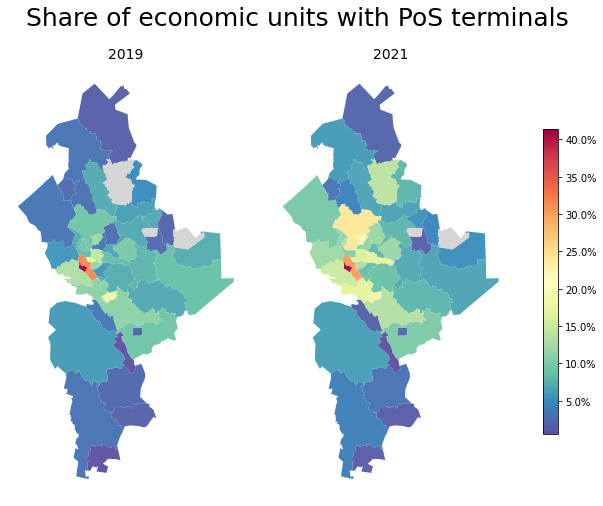

In [86]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 2, 1)
ax.set_axis_off()

ax_2 = fig.add_subplot(1, 1, 1)
ax_2.set_axis_off()


#Mapa de Nuevo Leon
nuevo_leon_2019.plot(column='share_est_pos_terminals', edgecolor = "black", linewidth = 0.0, alpha = 0.95, legend = False, cmap = 'Spectral_r', ax = ax, missing_kwds = dict(color = "lightgrey"))
nuevo_leon_2021.plot(column='share_est_pos_terminals', edgecolor = "black", linewidth = 0.0, alpha = 0.95, legend = True, cmap = 'Spectral_r', ax = ax_2, missing_kwds = dict(color = "lightgrey"), legend_kwds={'shrink': 0.7, 'format':'%.1f%%'})

ax.set_title("2019", size = 14)
ax_2.set_title("2021", size = 14)



fig.suptitle("Share of economic units with PoS terminals", size = 25)

### Asset turnover vs. Branches per Economic Unit

In [87]:
asset_turnover = main_df[['date_operational', '942f60788525ce9', 'geography', 'geography__ref', '940b060ccbf7cb7', 'd11b1e4d6a55d5a']].drop_duplicates()
asset_turnover = asset_turnover.groupby(['geography', 'geography__ref']).sum().reset_index()

In [88]:
asset_turnover = pd.merge(asset_turnover, main_df[['geography', 'geography__ref', 'date_operational', '2eee037c67fbe81']].drop_duplicates())
asset_turnover

,geography,geography__ref,942f60788525ce9,940b060ccbf7cb7,d11b1e4d6a55d5a,date_operational,2eee037c67fbe81
0,Abalá,477d47058648c7c,144.0,7.595800e+07,1.395560e+08,2019-12-01,NaN
1,Abalá,477d47058648c7c,144.0,7.595800e+07,1.395560e+08,2021-09-01,NaN
2,Abasolo,15a828c13efe8aa,4160.0,6.326568e+09,1.295292e+10,2019-12-01,5.0
3,Abasolo,15a828c13efe8aa,4160.0,6.326568e+09,1.295292e+10,2021-09-01,4.0
4,Abasolo,29a296d009179bd,726.0,1.823200e+08,1.294882e+09,2019-12-01,NaN
...,...,...,...,...,...,...,...
4884,Álvaro Obregón,12db53b4df1cf99,1364.0,5.804440e+08,1.934036e+09,2021-09-01,1.0
4885,Álvaro Obregón,5351cefd1383068,46026.0,3.936460e+11,2.073426e+12,2019-12-01,183.0
4886,Álvaro Obregón,5351cefd1383068,46026.0,3.936460e+11,2.073426e+12,2021-09-01,163.0
4887,Ánimas Trujano,723323489be08f3,478.0,2.189320e+08,1.639054e+09,2019-12-01,NaN


In [89]:
asset_turnover.loc[:,'asset_turnover'] = asset_turnover.loc[:,'d11b1e4d6a55d5a']/asset_turnover.loc[:,'940b060ccbf7cb7']
asset_turnover.loc[:,'branches_per_1000'] = (asset_turnover.loc[:,'2eee037c67fbe81']/asset_turnover.loc[:,'940b060ccbf7cb7'])*1000

Text(0.5, 0.98, 'Bank branches per 1,000 economic units vs. asset turnover ratio')

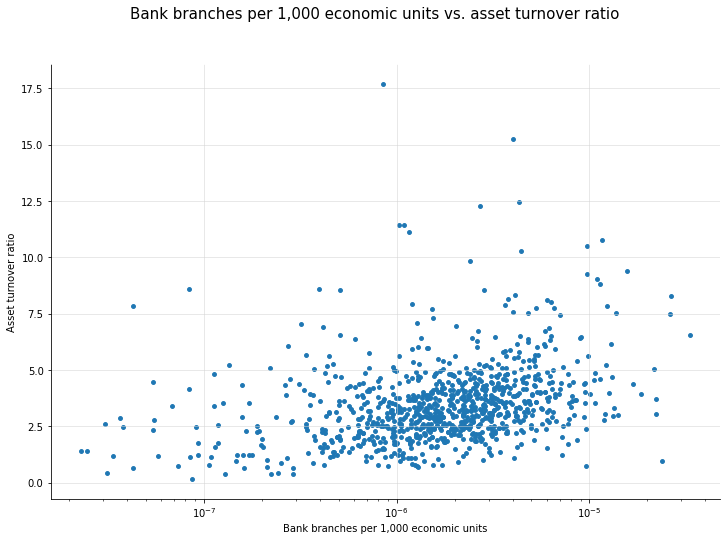

In [103]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(asset_turnover[asset_turnover['date_operational'] == '2019-12-01']['branches_per_1000'], asset_turnover[asset_turnover['date_operational'] == '2019-12-01']['asset_turnover'], s = 15)
ax.set_xscale('log')
ax.spines["top"].set_color("white")
ax.spines["right"].set_color("white")

ax.grid(color="lightgrey", lw = 0.5, zorder=1)
ax.set_xlabel("Bank branches per 1,000 economic units")
ax.set_ylabel("Asset turnover ratio")

fig.suptitle("Bank branches per 1,000 economic units vs. asset turnover ratio", size = 15)
